# Persist Benchmarks

In [25]:
# select measurement file
files = [
    "../output/2024-12-30 15-00-36 persist4.json",
]

# plot settings
show_error_bar = False
unit = "ms"

In [26]:
# parse data
import json

raw_data = []
for file_name in files:
    with open(file_name) as file:
        raw_data.extend(json.load(file))

In [27]:
from util.convert import convert_datasets
import pandas as pd

storage = convert_datasets(
    raw_data,
    "Storage",
    [("persistent_storage_write", "Storage Write")],
    ["mean", "min", "max", "options.object_size", "machine_name", "cold_start", "repetitions"],
    unwrapped=show_error_bar
)

baseline = convert_datasets(
    raw_data,
    "Persist",
    [("max_dirty_persist_latency_dirty_size", "Worst Case"), ("max_dirty_persist_latency_buffer_size", "Worst Case Buffer")],
    ["mean", "min", "max", "options.dirty_size", "options.buffer_size", "options.ram_overhead", "machine_name", "cold_start", "repetitions"],
    unwrapped=show_error_bar
)

dataset = pd.concat([storage, baseline])
dataset.head()

,mean,min,max,options.object_size,machine_name,cold_start,repetitions,ticks_per_ms,dataset_type,benchmark_title,benchmark_id,options.dirty_size,options.buffer_size,options.ram_overhead
0,318.4,312,376,0.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN,NaN
1,6136.1,5615,10821,4.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN,NaN
2,7404.8,6884,12089,8.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN,NaN
3,8646.6,8126,13331,12.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN,NaN
4,9888.8,9368,14573,16.0,esp32c3,0,10,16000,Storage,Storage Write,persistent_storage_write,NaN,NaN,NaN


In [28]:
# update the metrics in the following as we do not persist the datastructures of vNVHeaps explicitly in our benchmarks

ram_overhead = dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "options.ram_overhead"]
assert(len(ram_overhead.unique()) == 1)
ram_overhead = ram_overhead.unique()[0]

# add the ram overhead to the buffer size and the dirty size (we want to include it to the RAM we manage and need to persist)
dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "options.buffer_size"] += ram_overhead
dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "options.dirty_size"] += ram_overhead

# add the latency it takes to persist the amount of bytes that is equal to the ram overhead
mean = dataset.loc[(dataset["benchmark_id"] == "persistent_storage_write") & (dataset["options.object_size"] == ram_overhead), "mean"].iloc[0]
min = dataset.loc[(dataset["benchmark_id"] == "persistent_storage_write") & (dataset["options.object_size"] == ram_overhead), "min"].iloc[0]
max = dataset.loc[(dataset["benchmark_id"] == "persistent_storage_write") & (dataset["options.object_size"] == ram_overhead), "max"].iloc[0]

dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "mean"] += mean
dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "min"] += min
dataset.loc[(dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") | (dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size"), "max"] += max

In [29]:
from util.convert import display_dataset_infos

display_dataset_infos(dataset)

min        19.9
max    159309.1
Name: mean, dtype: float64

min     4265.1875
max    79420.5625
Name: mean, dtype: float64

min     9655.7500
max    39554.9625
Name: mean, dtype: float64

# Final Plot

In [30]:
scale = 0.5
scaled_dataset = dataset.copy()
scaled_dataset["options.object_size"] = scaled_dataset["options.object_size"]/1024
scaled_dataset["options.dirty_size"] = scaled_dataset["options.dirty_size"]/1024

storage_dataset = scaled_dataset[(scaled_dataset["benchmark_id"] == "persistent_storage_write") & (scaled_dataset["options.object_size"] <= 4) & (scaled_dataset["options.object_size"] >= scale) & (scaled_dataset["options.object_size"] % scale == 0)].copy()
storage_dataset["mean"] = storage_dataset["mean"].max()

plot_data = [{
    "name": "Unmanaged RAM",
    "x": "options.object_size",
    "y": "mean",
    "marker": "o",
    "use_edge_color": True,
    "data": storage_dataset,
},{
    "name": "vNV-Heaps",
    "x": "options.dirty_size",
    "y": "mean",
    "marker": "X",
    "data": scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size") & (scaled_dataset["options.dirty_size"] % scale == 0)],
}]
buf_size = scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_dirty_size") & (scaled_dataset["options.dirty_size"] % scale == 0)]["options.buffer_size"]
assert(len(buf_size.unique()) == 1)
buf_size = buf_size.unique()[0] / 1024

options1 = {
    "data": plot_data,
    "scale": unit,
    "x_label": "Max Dirty Size [kB]",
    "y_label": f"Latency [{unit}]",
    "width": 1,
    "height": 0.25,
    "title": f"Fixed App Size: {int(buf_size)}kB"
}

In [31]:
scale = 0.5
limit = 4

scaled_dataset = dataset.copy()
scaled_dataset["options.object_size"] /= 1024
scaled_dataset["options.buffer_size"] /= 1024

plot_data = [{
    "name": "",
    "x": "options.object_size",
    "y": "mean",
    "marker": "o",
    "use_edge_color": True,
    "data": scaled_dataset[(scaled_dataset["benchmark_id"] == "persistent_storage_write") & (scaled_dataset["options.object_size"] <= limit) & (scaled_dataset["options.object_size"] >= scale) & (scaled_dataset["options.object_size"] % scale == 0)],
},{
    "name": "",
    "x": "options.buffer_size",
    "y": "mean",
    "marker": "X",
    "data": scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") & (scaled_dataset["options.buffer_size"] % scale == 0)],
}]

dirty_size = scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") & (scaled_dataset["options.buffer_size"] % scale == 0)]["options.dirty_size"]
print(dirty_size)
dirty_size = dirty_size.max() / 1024

options2 = {
    "data": plot_data,
    "scale": unit,
    "x_label": "App Size [kB]",
    "y_label": f"Latency [{unit}]",
    "width": 1,
    "height": 0.25,
    "title": f"Fixed Dirty Size: {int(dirty_size)}kB"
}

0       512.0
16     1024.0
32     1536.0
48     2048.0
64     2048.0
80     2048.0
96     2048.0
112    2048.0
Name: options.dirty_size, dtype: float64


/home/markus/Documents/vnv_heap/zephyr/vnv_heap_benchmark/analysis/util/plot.py:183: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ncol = len(ax.legend().get_lines())


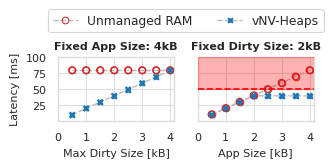

In [32]:
from util import convert
from util.plot import plot_lines, save_plot

axes = plot_lines([options1, options2])

offset_multiplier = 0.2
scaled = convert.scale_data(scaled_dataset[(scaled_dataset["benchmark_id"] == "max_dirty_persist_latency_buffer_size") & (scaled_dataset["options.buffer_size"] % scale == 0)], unit)
#line = scaled["mean"].max() + scaled["mean"].max() * offset_multiplier
line = 50
limit2 = (convert.scale_data(scaled_dataset[(scaled_dataset["benchmark_id"] == "persistent_storage_write") & (scaled_dataset["options.object_size"] <= limit)], unit))["mean"].max()
limit2 = 100

axes[1].axhline(line, ls='--', color="red", zorder=20)
axes[1].set_ylim(bottom=0, top=limit2)
axes[1].axhspan(line, limit2, alpha=0.3, color="red",zorder=10)
axes[0].legend(
    loc = "lower center",
    bbox_to_anchor=(1.1, 1.3),
    ncol=2,
    title=None,
    frameon=True
)
axes[1].get_legend().remove()

for ax in axes:
    ax.set_xticks([0,1,2,3,4])
    ax.set_xlim(0,4.15)
    ax.set_yticks([25,50,75,100])


save_plot("persist", False)